Here we estimate the following conditional expectation function:
$$
\mathbb{E}[valuation_i|ispolice_i]=\alpha+\beta_1 ispolice_i,
$$
using the entire sample where the number of bids received is strictly between 3 and 12.

In [1]:
import sys
import pandas as pd
import re

sys.path.append('../')

from functions import *

df = pd.read_csv("../../data/simulated.csv")

def comma(s):
    add_comma = lambda match: match.group(0).replace(" ", ", ")
    
    s = s.replace("\n", "")

    s = re.sub(r"([0-9\.]+\s)", add_comma, s)
    
    return eval(s)

df.bids = df.bids.apply(comma)

In [2]:
include = df[df.bidcount == 6]

bids = list(include.bids)
covariates = [[cov] for cov in list(include.ispolice)]

In [3]:
expected_upper, expected_lower, u_cdfs, l_cdfs = estimate_mean(bids, covariates, (0,9))

calculating values for covariate: [0.0] (1/2)
total time elapsed: 0.00017931999999998283s


/Users/liumukun/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


calculating values for covariate: [1.0] (2/2)
total time elapsed: 101.833144496s


In [4]:
def loss_function(c):
    a, b = c
    cef = lambda cov: a+b*cov[0]
    return get_loss_function(covariates, expected_upper, expected_lower, cef)

b_hat = optimize.brute(loss_function, ranges=[(0,2), (-1,1)])
# interval_lower = optimize.newton(lambda a_l, b_l: loss_function(a_l, b_l)-loss_function(b_hat)-10, b_hat-0.1)
# interval_upper = optimize.newton(lambda b_l, b_u: loss_function(b_l, b_u)-loss_function(b_hat)-10, b_hat+0.1)

In [5]:
b_hat

array([ 1.21504905, -0.26426016])

Text(0.5, 0, 'Loss function')

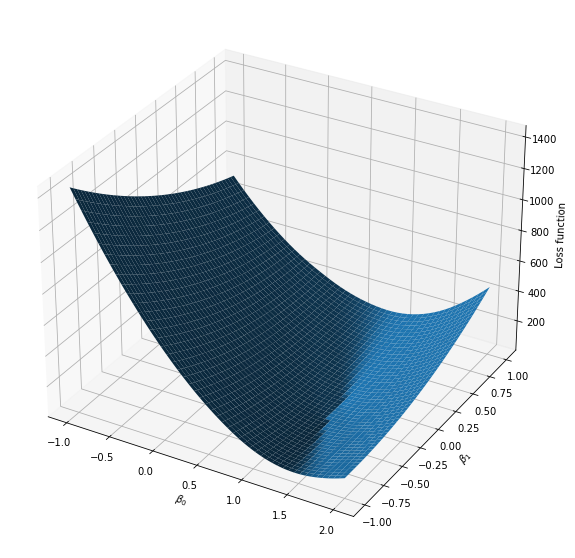

In [6]:
import matplotlib.pyplot as plt

x_points = np.linspace(-1,2,num=50)
y_points = np.linspace(-1,1,num=50)

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(x_points, y_points)
dps = ([np.ravel(X), np.ravel(Y)])
zs = np.array([loss_function(pair) for pair in list(zip(np.ravel(X), np.ravel(Y)))])
Z = zs.reshape(X.shape)

ax.plot_surface(X,Y,Z)
ax.set_ylabel(r"$\beta_1$")
ax.set_xlabel(r"$\beta_0$")
ax.set_zlabel(r"Loss function")

# plt.tight_layout()
# fig.savefig("loss_func.png", dpi=fig.dpi, bbox_inches="tight")
# plt.close()

In [7]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.titlepad'] = 10
plt.rcParams['axes.titleweight'] = 1000
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.facecolor'] = 'white'

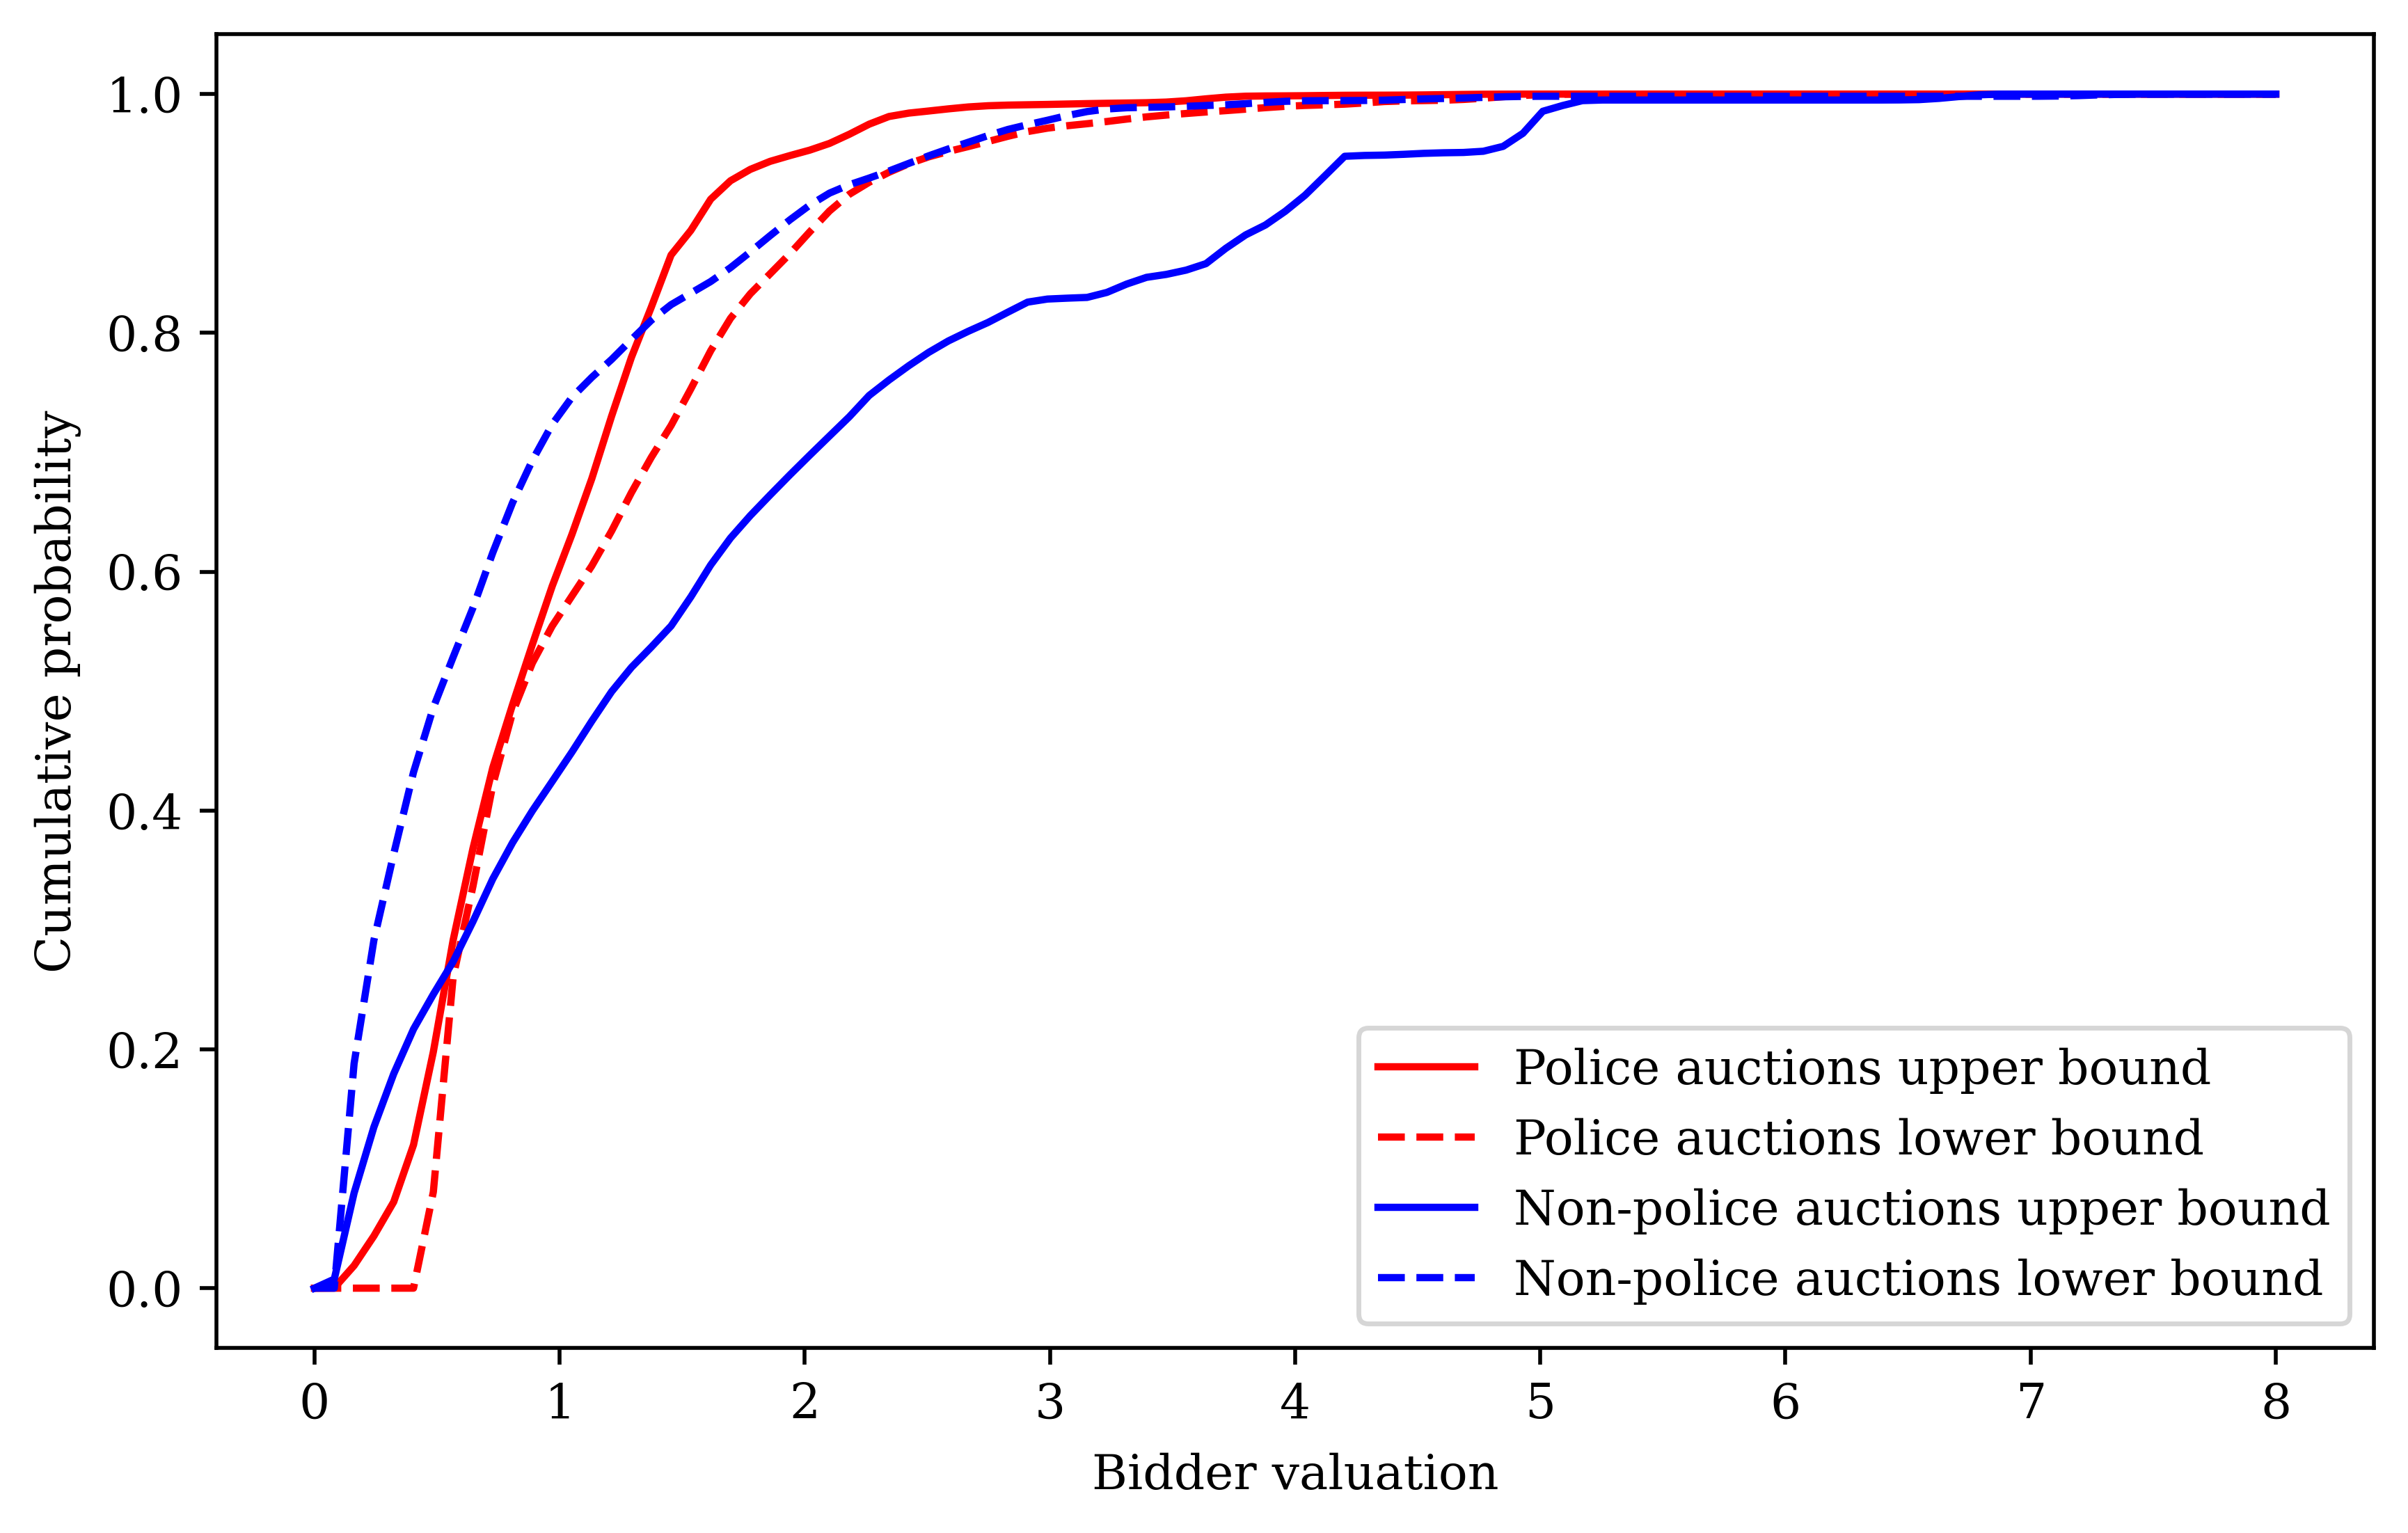

In [8]:
from scipy import interpolate
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

vals = np.linspace(0,8,num=100)

int_cdf_u_police = interpolate.interp1d(np.linspace(0,9,num=100), u_cdfs["[1.0]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_u_police(v) for v in vals], label="Police auctions upper bound", color="red")

int_cdf_l_police = interpolate.interp1d(np.linspace(0,9,num=100), l_cdfs["[1.0]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_l_police(v) for v in vals], label="Police auctions lower bound", color="red", linestyle="--")

int_cdf_u_not = interpolate.interp1d(np.linspace(0,9,num=100), u_cdfs["[0.0]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_u_not(v) for v in vals], label="Non-police auctions upper bound", color="blue")

int_cdf_l_not = interpolate.interp1d(np.linspace(0,9,num=100), l_cdfs["[0.0]"], bounds_error=False, fill_value=(0,1))
plt.plot(vals, [int_cdf_l_not(v) for v in vals], label="Non-police auctions lower bound", color="blue", linestyle="--")

plt.ylabel("Cumulative probability")
plt.xlabel("Bidder valuation")
plt.legend()

# plt.tight_layout()
# fig.savefig("cef1_base.png", dpi=fig.dpi, bbox_inches="tight")
# plt.close(fig)

In [9]:
from random import choices

def bootstrap(bids, covariates, repetition):
    
    estimates_lower = []
    estimates_upper = []
    data_pairs = [(bid, covariate) for bid, covariate in zip(bids, covariates)]
    
    for _ in range(repetition):
        resampled = choices(data_pairs, k=len(bids))
    
        bids = [r[0] for r in resampled]
        covariates = [r[1] for r in resampled]

        pdfs, pdfs_delta = get_order_statistic_pdfs(bids, covariates)
        
        expected_upper = {}
        expected_lower = {}
        
        for covariate in np.unique(covariates):
            lower, upper = get_estimated_means(pdfs, pdfs_delta, covariate, (-1,9))
            expected_upper[f"{covariate}"] = upper
            expected_lower[f"{covariate}"] = lower
        
        estimate = optimize.brute(lambda b: loss_function(covariates, expected_upper, expected_lower, b), ranges=[(0,2)])
        interval_lower = optimize.newton(lambda b_l: loss_function(b_l)-loss_function(estimate)-10, estimate-0.1)
        interval_upper = optimize.newton(lambda b_l: loss_function(b_l)-loss_function(estimate)-10, estimate+0.1)
        
        estimates_lower.append(interval_lower)
        estimates_upper.append(interval_upper)
        
    return (estimates_lower, estimates_upper)
    

In [11]:
interval_lower_b = optimize.newton(lambda b_l: loss_function([b_hat[0], b_l])-loss_function(b_hat)-1, b_hat[1]-0.1)
interval_upper_b = optimize.newton(lambda b_l: loss_function([b_hat[0], b_l])-loss_function(b_hat)-1, b_hat[1]+0.1)

interval_lower_a = optimize.newton(lambda b_l: loss_function([b_l, b_hat[1]])-loss_function(b_hat)-1, b_hat[0]-0.1)
interval_upper_a = optimize.newton(lambda b_l: loss_function([b_l, b_hat[1]])-loss_function(b_hat)-1, b_hat[0]+0.1)

interval_lower_a, interval_upper_a, interval_lower_b, interval_upper_b

RuntimeError: Tolerance of -0.00011642601570474587 reached. Failed to converge after 1 iterations, value is -0.16437658306317932.